<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>LangChain for Generative AI</h1>
<h1>Generative Models</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from IPython.display import Image

import requests
import shutil

import openai
from openai import OpenAI

import transformers
from transformers import pipeline
from transformers import set_seed
set_seed(42) # Set the seed to get reproducible results

from tqdm.notebook import tqdm

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: bd2418d30c476bc5452faaa2f8e9e7fa77b6d594

matplotlib  : 3.8.0
transformers: 4.41.1
requests    : 2.32.2
openai      : 1.30.5
pandas      : 2.1.4
numpy       : 1.26.4
watermark   : 2.4.3



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

## OpenAI

In [4]:
client = OpenAI()

The recommended model for exploration is `gpt-3.5-turbo`, so we'll stick with it for now. The basic setup is relatively straightforward:

### Simple interaction

In [5]:
response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
        {
            "role": "user", 
            "content": "What was Superman's weakness?"
        },
    ]
)

Which produces the expected response

In [6]:
response.choices[0].message.content

"Superman's weakness is Kryptonite, a mineral from his home planet of Krypton that is radioactive to him, weakening his powers and potentially killing him if exposed for too long."

### Multiple alternatives

To request multiple answers, we must include the `n` parameter with the number of answers we want

In [7]:
%%time
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "What are the different kinds of Kryptonite?"},
    ],
    n=3
)

CPU times: user 7.56 ms, sys: 3.39 ms, total: 10.9 ms
Wall time: 7.48 s


And we can access each of the answers individually int he choices list

In [8]:
for output in response.choices:
    print("==========")
    print(output.message.role.title()) 
    print("==========")
    print(output.message.content)
    print("==========\n")

Assistant
There are several different kinds of Kryptonite, each with unique properties and effects on the Kryptonian superhero Superman. Some of the most well-known types of Kryptonite include:

1. Green Kryptonite - The most commonly known form of Kryptonite, green Kryptonite weakens and can kill Superman. Its radiation is toxic to Kryptonians and can sap their powers.

2. Red Kryptonite - Red Kryptonite causes unpredictable and temporary changes in Superman's personality, behavior, and powers. The effects wear off eventually, but can range from making Superman evil to giving him new abilities.

3. Blue Kryptonite - Blue Kryptonite affects Bizarro, a flawed clone of Superman, in the same way that green Kryptonite affects Superman. It has no effect on Superman himself.

4. White Kryptonite - White Kryptonite is deadly to all plant life, including Kryptonian plant life. It has no effect on Superman himself.

5. Gold Kryptonite - Gold Kryptonite permanently strips Superman of his powers.

### Language Translation

In [9]:
response = client.chat.completions.create(
    model='gpt-3.5-turbo',
    messages=[{"role": "system", "content": "You're a professional English-Italian translator."}, 
              {"role": "user", "content": "Translate 'Be the change that you wish to see in the world.' into Italian"}],
    temperature=0,
)

In [10]:
response.choices[0].message.content

'"Sii il cambiamento che desideri vedere nel mondo."'

### Image generation

In [11]:
prompt = "A wimsical image of a toy duck with an eye patch and hat floating in the clouds"

In [12]:
%%time
response = client.images.generate(
    model="dall-e-3",
    prompt=prompt,
    n=1,
    size="1024x1024",
    response_format="url",
)

CPU times: user 7.05 ms, sys: 2.82 ms, total: 9.86 ms
Wall time: 15.6 s


Utility function to download the image

In [13]:
def download_file(url, filename):
    with requests.get(url, stream=True) as r:
        total_length = int(r.headers.get("Content-Length"))
        with tqdm.wrapattr(r.raw, "read", total=total_length, desc=filename) as raw:
            with open(filename, 'wb')as output:
                shutil.copyfileobj(raw, output)

In [14]:
image_dir = 'images/'

In [15]:
image_url = response.data[0].url

In [16]:
image_filename = os.path.join(image_dir, 'ducky.png')
download_file(image_url, image_filename)

images/ducky.png:   0%|          | 0/3162696 [00:00<?, ?it/s]

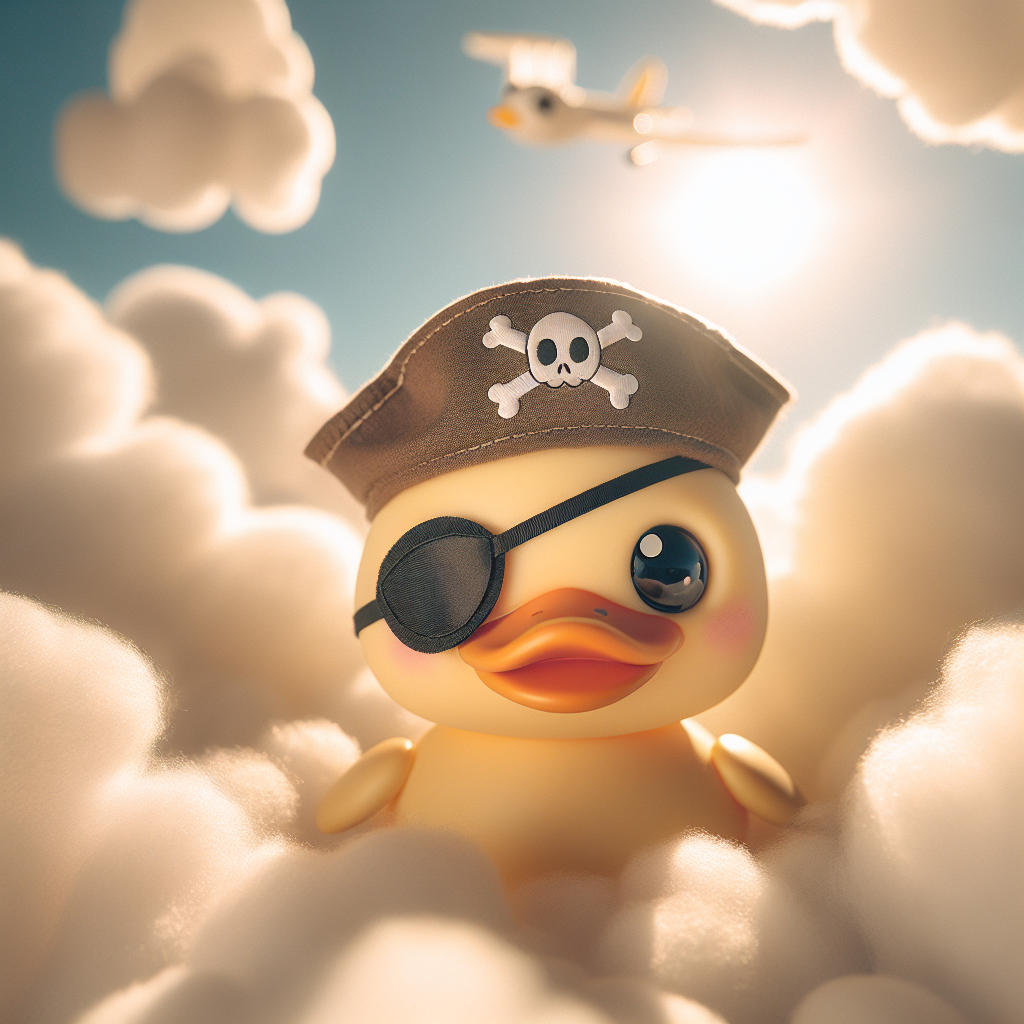

In [17]:
Image(filename=image_filename)

## HuggingFace

In [18]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
unmasker("Artificial Intelligence [MASK] take over the world.")

[{'score': 0.31824299693107605,
  'token': 2064,
  'token_str': 'can',
  'sequence': 'artificial intelligence can take over the world.'},
 {'score': 0.18299730122089386,
  'token': 2097,
  'token_str': 'will',
  'sequence': 'artificial intelligence will take over the world.'},
 {'score': 0.0560012087225914,
  'token': 2000,
  'token_str': 'to',
  'sequence': 'artificial intelligence to take over the world.'},
 {'score': 0.045194774866104126,
  'token': 2015,
  'token_str': '##s',
  'sequence': 'artificial intelligences take over the world.'},
 {'score': 0.045152731239795685,
  'token': 2052,
  'token_str': 'would',
  'sequence': 'artificial intelligence would take over the world.'}]

### Question answering

In [20]:
text = """Dear Amazon, last week I ordered an Optimus Prime action figure \
from your online store in Germany. Unfortunately, when I opened the package, \
I discovered to my horror that I had been sent an action figure of Megatron \
instead! As a lifelong enemy of the Decepticons, I hope you can understand my \
dilemma. To resolve the issue, I demand an exchange of Megatron for the \
Optimus Prime figure I ordered. Enclosed are copies of my records concerning \
this purchase. I expect to hear from you soon. Sincerely, Bumblebee."""

In [21]:
reader = pipeline("question-answering")
question = "What does the customer want?"
outputs = reader(question=question, context=text)
pd.DataFrame([outputs])    

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


score  start  end                   answer
0  0.631292    335  358  an exchange of Megatron

### Named Entity Recognition

In [22]:
ner_tagger = pipeline("ner", aggregation_strategy="simple")
outputs = ner_tagger(text)
pd.DataFrame(outputs)    

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTra

entity_group     score           word  start  end
0          ORG  0.879010         Amazon      5   11
1         MISC  0.990859  Optimus Prime     36   49
2          LOC  0.999755        Germany     90   97
3         MISC  0.556572           Mega    208  212
4          PER  0.590255         ##tron    212  216
5          ORG  0.669693         Decept    253  259
6         MISC  0.498348        ##icons    259  264
7         MISC  0.775362       Megatron    350  358
8         MISC  0.987854  Optimus Prime    367  380
9          PER  0.812097      Bumblebee    502  511

<center>
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</center>